# Does the Chinese Yuan move with the price of Bitcoin?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
#plt.style.use('fivethirtyeight')
plt.rc('figure', figsize=(13, 7))
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

from datetime import datetime
import sklearn.preprocessing
scaler = sklearn.preprocessing.MinMaxScaler()
from scipy import stats

import wrangle
from pandas.plotting import register_matplotlib_converters


# <div class="alert alert-block alert-info"> <b>Acquire<b> </div>
    
### Steps:
    
> 1. Read the csv files into a dataframe
2. Gather info on dataframes to see what must be prepped

In [2]:
cny = pd.read_csv('USD_CNY.csv',sep=',', skipinitialspace=True)
cny.head()

,Date,Price,Open,High,Low,Change %
0,"Dec 04, 2020",6.5301,6.5431,6.5529,6.5268,-0.18%
1,"Dec 03, 2020",6.5418,6.5540,6.5664,6.5423,-0.31%
2,"Dec 02, 2020",6.5622,6.5639,6.5692,6.5519,-0.13%
3,"Dec 01, 2020",6.5705,6.5789,6.5875,6.5606,-0.08%
4,"Nov 30, 2020",6.5760,6.5768,6.5950,6.5708,0.03%


In [3]:
cny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1296 non-null   object 
 1   Price     1296 non-null   float64
 2   Open      1296 non-null   float64
 3   High      1296 non-null   float64
 4   Low       1296 non-null   float64
 5   Change %  1296 non-null   object 
dtypes: float64(4), object(2)
memory usage: 60.9+ KB


In [4]:
# as we read the the btc csv, we have to call 'thousands' as this will be neccessary for the minmax scaler.

btc = pd.read_csv('BTC_USD.csv',sep=',', skipinitialspace=True, thousands=',')
btc.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Dec 06, 2020",19165.0,19157.0,19248.0,19015.6,2.72K,0.04%
1,"Dec 05, 2020",19157.0,18657.0,19157.0,18657.0,3.66K,2.68%
2,"Dec 04, 2020",18657.0,19452.0,19452.0,18657.0,8.65K,-4.06%
3,"Dec 03, 2020",19447.0,19241.0,19560.0,18999.4,5.25K,1.07%
4,"Dec 02, 2020",19241.0,18807.0,19275.0,18538.0,7.63K,2.31%


In [5]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1827 non-null   object 
 1   Price     1827 non-null   float64
 2   Open      1827 non-null   float64
 3   High      1827 non-null   float64
 4   Low       1827 non-null   float64
 5   Vol.      1827 non-null   object 
 6   Change %  1827 non-null   object 
dtypes: float64(4), object(3)
memory usage: 100.0+ KB


## Dataframe preparation Plans

> - Will drop unneccessary columns 
- There are more btc rows than found in the cny dataframe. 
- Dates will need to be changed to datetime
- columns are listed in reverse. Historical data will need to be changed to oldest from most recent.

# <div class="alert alert-block alert-info"> <b>Prepare<b> </div>

In [6]:
def prep_cny(df):
    
    '''
    This function takes in a dataframe and drops unneccessary columns, then renames
    the price column. From there the date column is converted to datetime and the clean df
    is returned.
    '''
    
    # dropping unneeded columns
    df.drop(columns = ['Open',
                  'High',
                  'Low',
                   'Change %'], inplace = True)
    
    #renameing the price column for simplistic exporation
    df.rename(columns={'Price':'cny_price'}, inplace=True)
    
    # converting the date column to datetime
    df.Date = pd.to_datetime(df.Date)
    
    return df

In [7]:
cny = prep_cny(cny)

In [8]:
def prep_btc(df):
    
    '''
    This function takes in a dataframe and drops unneccessary columns, then renames
    the price column. From there the date column is converted to datetime and the clean df
    is returned. Two functions are needed as the btc df has different information than the cny df.
    '''
    
    # dropping columns
    btc.drop(columns = ['Open',
                  'High',
                  'Low',
                    'Vol.',
                   'Change %'], inplace = True)
    
    # converting to datetime
    btc.Date = pd.to_datetime(btc.Date)
    
    # changing datatype to float from object.
    btc['Price'].astype(float)
    
    return df

In [9]:
btc = prep_btc(btc)

In [10]:
### Merging the dataframes together

df = pd.merge(left=btc, right=cny, left_on='Date', right_on='Date')


In [11]:
### Notice we now have an equal amount of rows. 

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1295 entries, 0 to 1294
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1295 non-null   datetime64[ns]
 1   Price      1295 non-null   float64       
 2   cny_price  1295 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 40.5 KB


In [12]:
### Dropping 'Date' for the scaler

df.drop(columns = ['Date'], inplace = True)

In [13]:
### Flipping the columns to be oldest to most recent.

df = df.iloc[::-1]

In [14]:
def scale_minmax(df):
    
    '''
    This function takes in a dataframe and calls in the minmax scaler, fits it,
    then transforms the df. From there it is turned to a dataframe with
    relabeled columns.
    '''
    
    # calling in the scaler
    scaler = sklearn.preprocessing.MinMaxScaler()
    
    # fitting the scaler to the df
    scaler.fit(df)
    
    # transofrming the df with the scaler
    df_scaled = scaler.transform(df)
    
    # creating a new dataframe with the scaled data
    df_s = pd.DataFrame(df_scaled)
    
    # assigning labels to the data
    df_s.columns=['BTC','CNY']
    
    return df_s

In [15]:
df_s = scale_minmax(df)

In [16]:
df_s

,BTC,CNY
0,0.001956,0.152984
1,0.003203,0.162875
2,0.003094,0.174744
3,0.002897,0.185515
4,0.005040,0.204748
...,...,...
1290,1.000000,0.337400
1291,0.954520,0.331355
1292,0.976975,0.322233
1293,0.987634,0.299813


In [17]:
### Time to Split ###

train_size = int(len(df_s) * .5)
validate_size = int(len(df_s) * .3)
test_size = int(len(df_s) - train_size - validate_size)

validate_end_index = train_size + validate_size

In [18]:
train = df_s[: train_size]
validate = df_s[train_size:validate_end_index]
test = df_s[validate_end_index:]
train

,BTC,CNY
0,0.001956,0.152984
1,0.003203,0.162875
2,0.003094,0.174744
3,0.002897,0.185515
4,0.005040,0.204748
...,...,...
642,0.373455,0.120123
643,0.367313,0.134960
644,0.348681,0.143203
645,0.367417,0.163315


In [19]:
validate_end_index

1035

# <div class="alert alert-block alert-info"> <b>Exploration<b> </div>

In [20]:
btc_c = btc.drop(columns = ['Date'])
btc_c = btc_c.iloc[::-1]

In [21]:
cny_c = cny.drop(columns = ['Date'])
cny_c = cny_c.iloc[::-1]

Text(0, 0.5, 'Price')

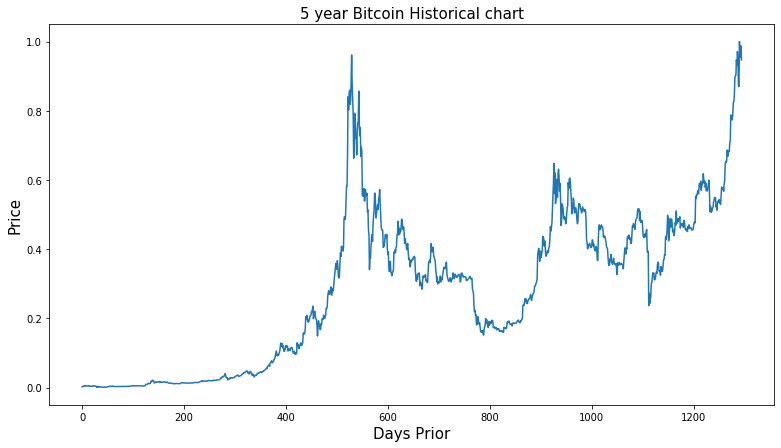

In [22]:
plt.plot(df_s.BTC)
plt.title(f"5 year Bitcoin Historical chart", size=15)
plt.xlabel('Days Prior', size=15)
plt.ylabel('Price', size=15)
#plt.style.use('fivethirtyeight')

Text(0, 0.5, 'Price')

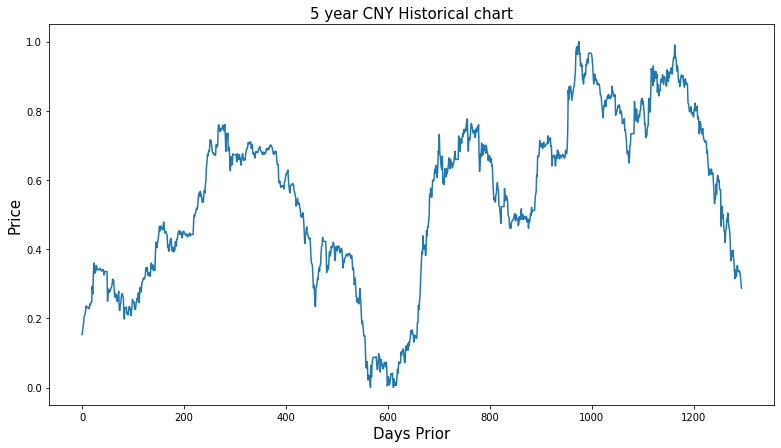

In [23]:
plt.plot(df_s.CNY)
plt.title(f"5 year CNY Historical chart", size=15)
plt.xlabel('Days Prior', size=15)
plt.ylabel('Price', size=15)
#plt.style.use('fivethirtyeight')

No handles with labels found to put in legend.


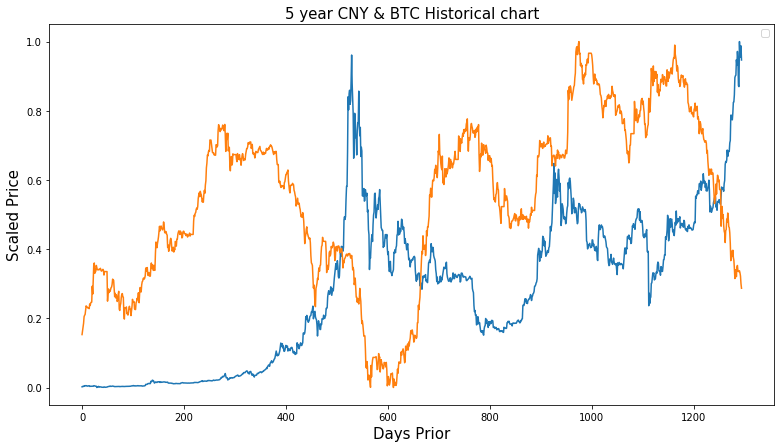

In [24]:
plt.plot(df_s)
plt.title(f"5 year CNY & BTC Historical chart", size=15)
plt.xlabel('Days Prior', size=15)
plt.ylabel('Scaled Price', size=15)
#plt.style.use('fivethirtyeight')
plt.legend()

## Hypothesis Testing - Is there a relationship with CNY and BTC?

 $H_o$ - There is no relationship with the Chinese Yuan and Bitcoin

 $H_a$ - There is a relationship with the Chinese Yuan and Bitcoin

 $a = .05$

In [25]:
r, p = stats.pearsonr(df_s.BTC, df_s.CNY)
print('r = ',r)
print('p = ',p,'\n')

print('Conclusion: We reject the null hypothesis that there is no relationship between the Chinese Yuan and Bitcoin.')

r =  0.12533282411841334
p =  6.075823617519498e-06 

Conclusion: We reject the null hypothesis that there is no relationship between the Chinese Yuan and Bitcoin.


# <div class="alert alert-block alert-info"> <b>Modeling<b> </div>

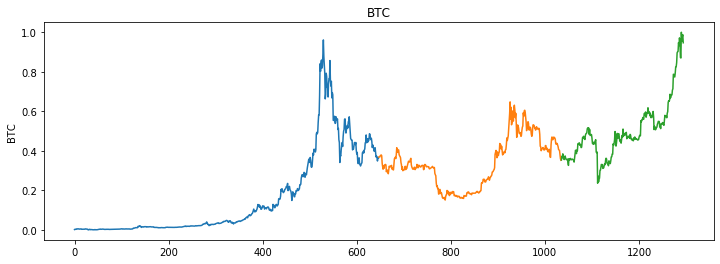

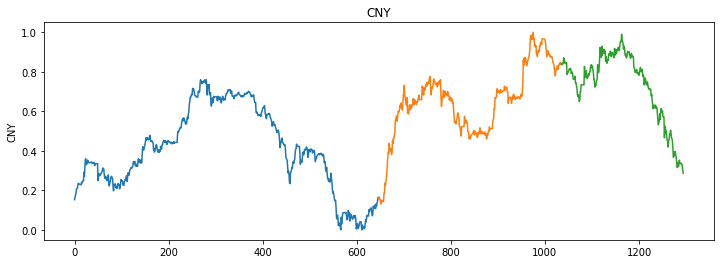

In [26]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

### Baseline - Last observed Value

In [27]:
btc_baseline = .363024

In [28]:
cny_baseline = .164853

In [29]:
yhat_df = pd.DataFrame({'BTC': [btc_baseline], 
                        'CNY': [cny_baseline]}, 
                      index = validate.index)

yhat_df.head()

,BTC,CNY
647,0.363024,0.164853
648,0.363024,0.164853
649,0.363024,0.164853
650,0.363024,0.164853
651,0.363024,0.164853


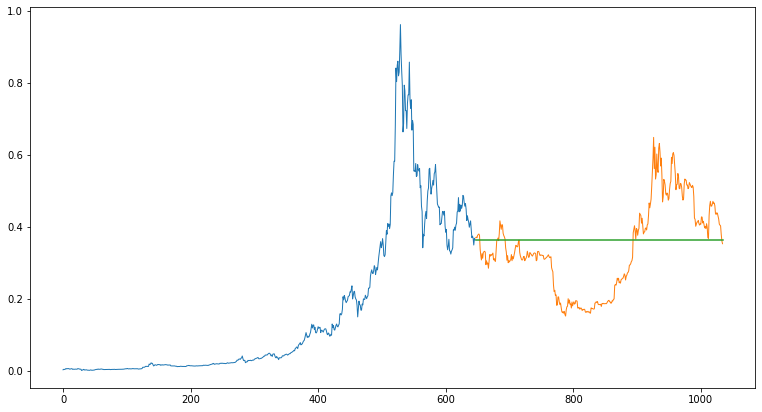

In [30]:
plt.plot(train['BTC'], label='Train', linewidth=1)
plt.plot(validate['BTC'], label='Validate', linewidth=1)
plt.plot(yhat_df['BTC'])

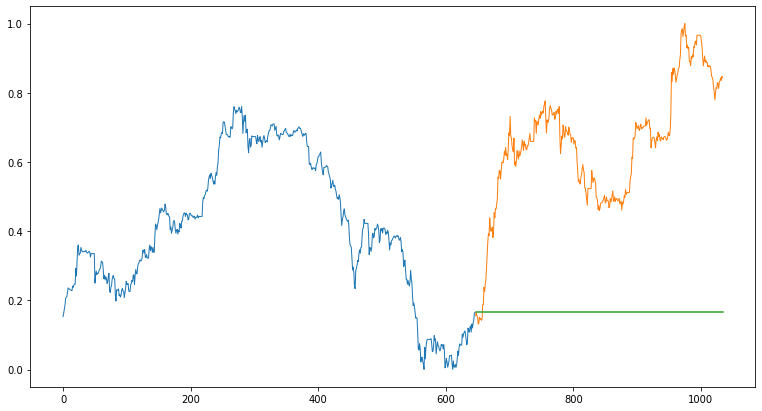

In [31]:
plt.plot(train['CNY'], label='Train', linewidth=1)
plt.plot(validate['CNY'], label='Validate', linewidth=1)
plt.plot(yhat_df['CNY'])

## FB Prophet

In [32]:
### bringing in fresh csv's
cny = pd.read_csv('USD_CNY.csv',sep=',', skipinitialspace=True)
cny.head()

cny.drop(columns = ['Open',
                  'High',
                  'Low',
                   'Change %'], inplace = True)

cny.rename(columns={'Date':'ds','Price':'y'}, inplace=True)

cny.ds = pd.to_datetime(cny.ds)

In [33]:
cny = cny.iloc[::-1]

In [34]:
cny

,ds,y
1295,2015-12-07,6.4082
1294,2015-12-08,6.4172
1293,2015-12-09,6.4280
1292,2015-12-10,6.4378
1291,2015-12-11,6.4553
...,...,...
4,2020-11-30,6.5760
3,2020-12-01,6.5705
2,2020-12-02,6.5622
1,2020-12-03,6.5418


In [35]:
m = Prophet()
m.fit(cny)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [36]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1656,2021-11-30
1657,2021-12-01
1658,2021-12-02
1659,2021-12-03
1660,2021-12-04


In [37]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1656,2021-11-30,6.204494,3.712012,8.549780
1657,2021-12-01,6.202424,3.730689,8.562110
1658,2021-12-02,6.201164,3.695284,8.568676
1659,2021-12-03,6.200784,3.679488,8.572724
1660,2021-12-04,6.092663,3.556552,8.460797


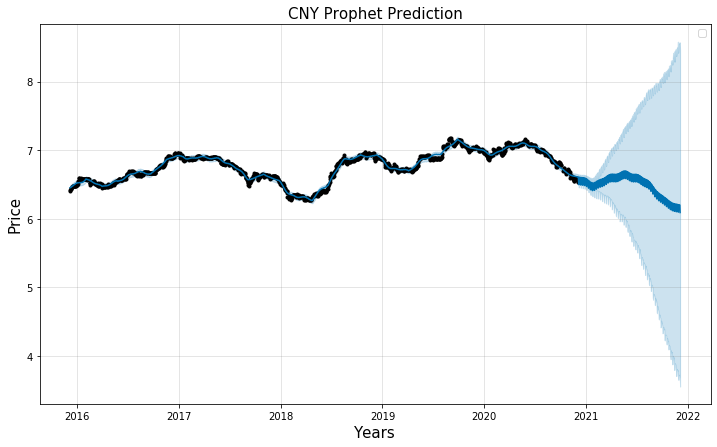

In [38]:
fig0 = m.plot(forecast)
plt.title(f"CNY Prophet Prediction", size=15)
plt.xlabel('Years', size=15)
plt.ylabel('Price', size=15)
plt.legend()


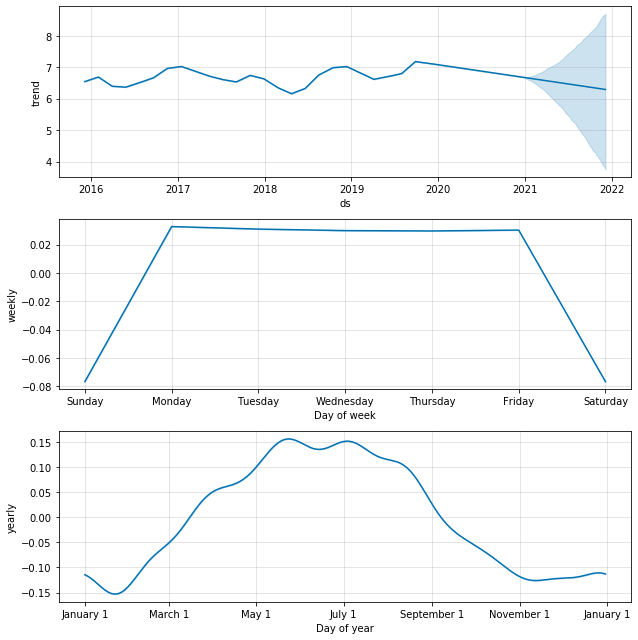

In [39]:
fig1 = m.plot_components(forecast)

In [40]:
btc = pd.read_csv('BTC_USD.csv',sep=',', skipinitialspace=True, thousands=',')

btc.drop(columns = ['Open',
                  'High',
                  'Low',
                    'Vol.',
                   'Change %'], inplace = True)

btc.Date = pd.to_datetime(btc.Date)
btc['Price'].astype(float)

btc.rename(columns={'Date':'ds','Price':'y'}, inplace=True)

btc = btc.iloc[::-1]

In [41]:
btc

,ds,y
1826,2015-12-06,390.6
1825,2015-12-07,396.7
1824,2015-12-08,420.8
1823,2015-12-09,418.7
1822,2015-12-10,414.9
...,...,...
4,2020-12-02,19241.0
3,2020-12-03,19447.0
2,2020-12-04,18657.0
1,2020-12-05,19157.0


In [42]:
m0 = Prophet()
m0.fit(btc)

future0 = m0.make_future_dataframe(periods=365)
future0.tail()

forecast0 = m0.predict(future)
forecast0[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1656,2021-11-30,21840.111618,10934.198077,32676.276002
1657,2021-12-01,21901.082824,11035.208654,32510.597253
1658,2021-12-02,21931.718225,11198.257271,32910.295029
1659,2021-12-03,21995.455929,11569.348627,33063.351574
1660,2021-12-04,22054.780190,11151.192225,32635.247556


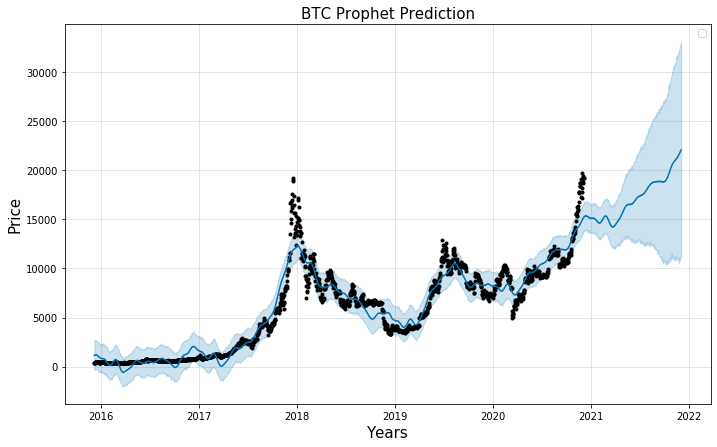

In [44]:
fig2 = m0.plot(forecast0)
plt.title(f"BTC Prophet Prediction", size=15)
plt.xlabel('Years', size=15)
plt.ylabel('Price', size=15)
plt.legend()

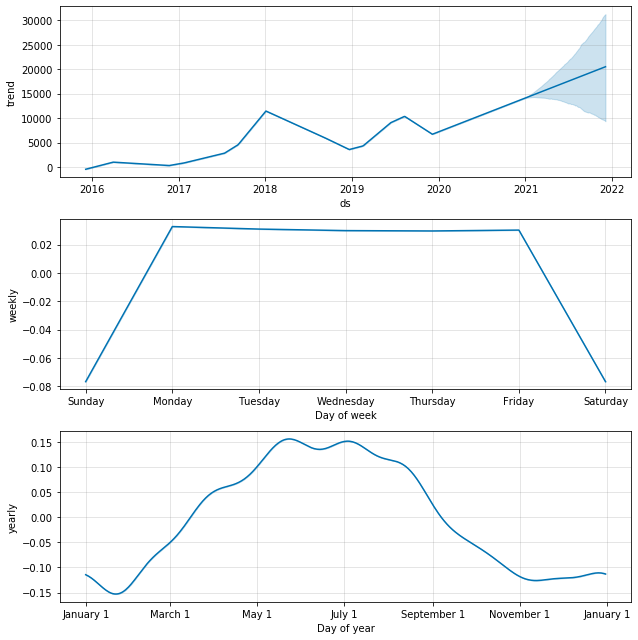

In [46]:
fig3 = m.plot_components(forecast0)